In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

import pickle

coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/gd1_mem.fits.gz')

In [8]:
dist = 8.*u.kpc
arr_dist = np.ones(len(t))*dist
ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(gc.GD1)

In [9]:
pdist = np.load('../data/gd1_phi1_dist.npy')
poly_dist = np.poly1d(pdist)

In [10]:
arr_dist = poly_dist(c.phi1.value)*u.kpc
ceq_nc = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=arr_dist,
                  pm_ra_cosdec=t['pmra']*u.mas/u.yr, pm_dec=t['pmdec']*u.mas/u.yr,
                  radial_velocity=np.zeros(len(t))*u.km/u.s, frame='icrs')
ceq = gc.reflex_correct(ceq_nc)
c_gal = ceq.transform_to(coord.Galactic)

c = ceq.transform_to(gc.GD1)

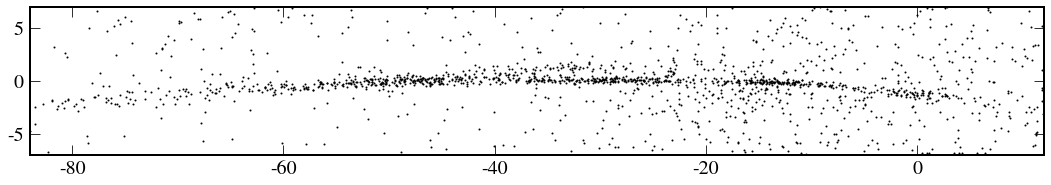

In [11]:
plt.figure(figsize=(15,7))
plt.plot(c.phi1, c.phi2, 'k.', ms=2)

# phi1_ = np.linspace(-80,5,100)
# phi2_ = poly_track(phi1_)
# plt.plot(phi1_, phi2_, 'r-')
# plt.plot(phi1_, phi2_+0.6, 'r-', alpha=0.3)
# plt.plot(phi1_, phi2_-0.6, 'r-', alpha=0.3)

plt.xlim(-84,12)
plt.ylim(-7,7)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [12]:
ind_stream = (c.phi1.value>-35) & (c.phi1.value<-29) & (c.phi2.value>-0.4) & (c.phi2.value<0.5)
ind_spur = (c.phi1.value>-35) & (c.phi1.value<-29) & (c.phi2.value>0.5) & (c.phi2.value<2)
ind_off_spur = (c.phi1.value>-35) & (c.phi1.value<-29) & (c.phi2.value>-1.9) & (c.phi2.value<-0.4)

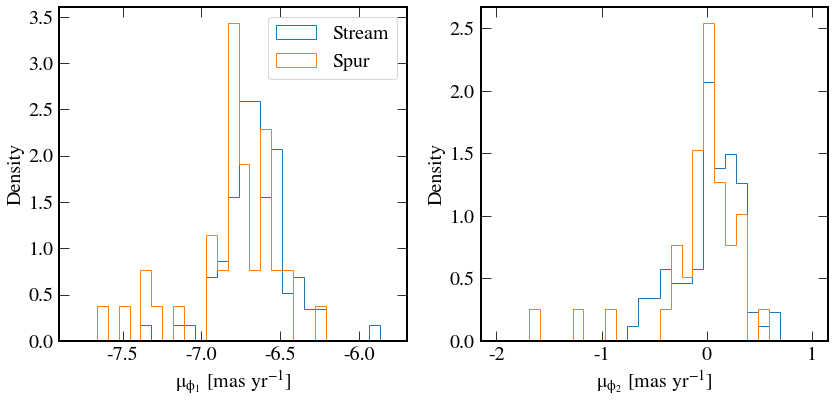

In [25]:
masks = [ind_stream, ind_spur, ind_off_spur]
labels = ['Stream', 'Spur', 'Off-spur']

fig, ax = plt.subplots(1,2,figsize=(12,6))

for e, ind in enumerate(masks[:2]):
    plt.sca(ax[0])
    plt.hist(c.pm_phi1_cosphi2[ind].value, bins=np.linspace(-7.8,-5.8,30), density=True, histtype='step', 
             label=labels[e])

    plt.sca(ax[1])
    plt.hist(c.pm_phi2[ind].value, bins=np.linspace(-2,1,30), density=True, histtype='step', 
             label=labels[e])

plt.sca(ax[0])
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('Density')
plt.legend()

plt.sca(ax[1])
plt.xlabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.ylabel('Density')

plt.tight_layout()

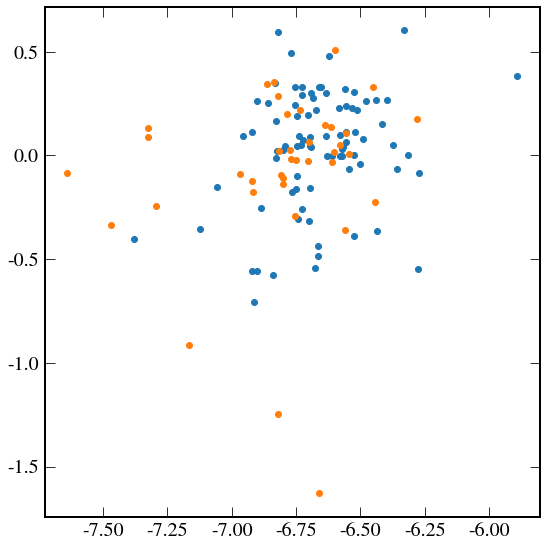

In [30]:
for e, ind in enumerate(masks[:2]):
    plt.plot(c.pm_phi1_cosphi2[ind], c.pm_phi2[ind], 'o')

plt.tight_layout()

In [34]:
for e, ind in enumerate(masks[:2]):
    print('{:s} pm_phi1 {:.2f} pm_phi2 {:.2f}'.format(labels[e], np.median(c.pm_phi1_cosphi2[ind]), 
                                                      np.median(c.pm_phi2[ind])))


Stream pm_phi1 -6.68 mas / yr pm_phi2 0.06 mas / yr
Spur pm_phi1 -6.77 mas / yr pm_phi2 -0.00 mas / yr


In [38]:
for e, ind in enumerate(masks[:2]):
    print('{:s} pm_ra {:.2f} pm_dec {:.2f}'.format(labels[e], 
                                                   np.median(ceq_nc.pm_ra_cosdec[ind]), 
                                                   np.median(ceq_nc.pm_dec[ind])))

Stream pm_ra -6.33 mas / yr pm_dec -11.65 mas / yr
Spur pm_ra -6.26 mas / yr pm_dec -11.91 mas / yr


In [39]:
wra = (t['pmra_error'])**-2
wdec = (t['pmdec_error'])**-2
for e, ind in enumerate(masks[:2]):
    print('{:s} pm_ra {:.2f} pm_dec {:.2f}'.format(labels[e], 
                                                   np.average(ceq_nc.pm_ra_cosdec[ind], weights=wra[ind]), 
                                                   np.average(ceq_nc.pm_dec[ind], weights=wdec[ind])))


Stream pm_ra -6.37 mas / yr pm_dec -11.69 mas / yr
Spur pm_ra -5.99 mas / yr pm_dec -12.07 mas / yr


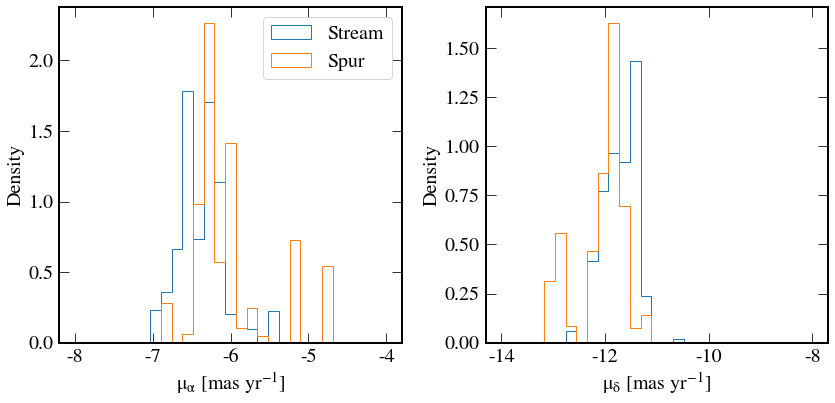

In [41]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

for e, ind in enumerate(masks[:2]):
    plt.sca(ax[0])
    plt.hist(ceq_nc.pm_ra_cosdec[ind].value, bins=np.linspace(-8,-4,30), density=True, histtype='step', 
             label=labels[e], weights=wra[ind])

    plt.sca(ax[1])
    plt.hist(ceq_nc.pm_dec[ind].value, bins=np.linspace(-14,-8,30), density=True, histtype='step', 
             label=labels[e], weights=wdec[ind])

plt.sca(ax[0])
plt.xlabel('$\mu_{\\alpha}$ [mas yr$^{-1}$]')
plt.ylabel('Density')
plt.legend()

plt.sca(ax[1])
plt.xlabel('$\mu_{\delta}$ [mas yr$^{-1}$]')
plt.ylabel('Density')

plt.tight_layout()

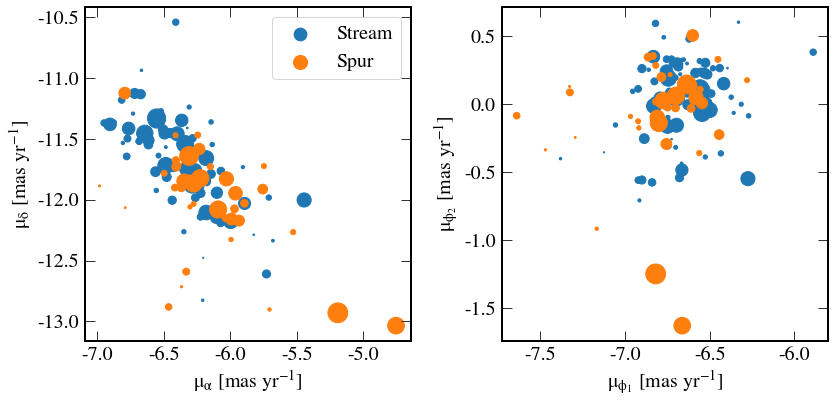

In [51]:
w = np.sqrt(wra**2 + wdec**2)

fig, ax = plt.subplots(1,2, figsize=(12,6))

for e, ind in enumerate(masks[:2]):
    plt.sca(ax[0])
    plt.scatter(ceq_nc.pm_ra_cosdec[ind], ceq_nc.pm_dec[ind], s=w[ind]*2, label=labels[e])

    plt.sca(ax[1])
    plt.scatter(c.pm_phi1_cosphi2[ind], c.pm_phi2[ind], s=w[ind]*2, label=labels[e])

plt.sca(ax[0])
plt.xlabel('$\mu_{\\alpha}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]')
plt.legend()

plt.sca(ax[1])
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.tight_layout()
plt.savefig('../plots/spur_pm_offset.png')